# Import des librairies

In [22]:
%load_ext autoreload
%autoreload 2

In [23]:
from functions import randomforestclass
from functions import download
from functions import isolation_forest

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

# Téléchargement du dataset 

In [6]:
downloader_object = download.downloader('./data')

downloader_object.data_download('valeursfoncieres-2019.txt', 'https://www.data.gouv.fr/fr/datasets/r/3004168d-bec4-44d9-a781-ef16f41856a2')

Data downloading...
Download finished


# Netttoyage du dataset

In [13]:
df_base = pd.read_csv("./data/RAW/valeursfoncieres-2019.txt", sep = '|', decimal = ',', usecols = ['Nature mutation', 'Valeur fonciere', 'Code postal', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot', 'Nombre de lots', 'Type local', 'Nombre pieces principales', "Surface terrain", "Surface reelle bati"])

In [14]:
df_base = df_base[["Valeur fonciere", "Code postal","Nombre de lots", "Nombre pieces principales", "Surface terrain", "Type local", "Surface reelle bati"]][df_base["Nature mutation"].str.contains("Vente", regex=True)]

In [15]:
df_base = df_base.dropna(subset=["Type local"])

In [16]:
df_base = df_base[["Valeur fonciere", "Code postal","Nombre de lots", "Nombre pieces principales", "Surface terrain", "Surface reelle bati", "Type local"]][df_base["Type local"].str.contains("Appartement|Maison", regex=True)]

In [17]:
df_preclean = df_base.dropna(subset=['Valeur fonciere'])
df_preclean = df_preclean.dropna(subset=['Code postal'])
df_preclean = df_preclean.dropna(subset=['Surface reelle bati'])
df_preclean = df_preclean[df_preclean["Nombre de lots"] < 6]
df_preclean = df_preclean[df_preclean["Nombre pieces principales"] != 0]
df_preclean = df_preclean[df_preclean["Surface reelle bati"] > 8]
df_toIF = df_preclean.fillna(0)

In [18]:
df_toIF.to_csv("./data/CURATED/csv_clean_1.csv")

del df_base
del df_preclean
del df_toIF

# Isolation forest

In [25]:
isolation_forest.isolation_forest('./data/CURATED/csv_clean_1.csv', './data/CURATED/anomaly_csv_clean_1.csv')

df_anomaly = pd.read_csv('./data/CURATED/anomaly_csv_clean_1.csv', sep = ',', decimal = ',')
df_csv_clean = pd.read_csv('./data/CURATED/csv_clean_1.csv', sep = ',', decimal = ',')
df_anomaly = df_anomaly.drop(columns = ['Unnamed: 0'])
df_anomaly = df_anomaly.drop(columns = ['Valeur fonciere', 'Code postal', 'Nombre de lots', 'Nombre pieces principales', 'Surface terrain', 'Surface reelle bati', 'scores'])
df_anomaly = df_anomaly.rename(columns = {'Unnamed: 0.1':'Unnamed: 0'})
df_add_anomaly = df_csv_clean.merge(df_anomaly, how = 'left', on = 'Unnamed: 0')
df_add_anomaly = df_add_anomaly.fillna(0)
df_add_anomaly = df_add_anomaly[df_add_anomaly["anomaly"] == 0]
df_add_anomaly = df_add_anomaly.drop(columns = ['Unnamed: 0', 'anomaly'])
df_add_anomaly.to_csv('./data/CURATED/csv_clean_2.csv')

del df_anomaly
del df_csv_clean
del df_add_anomaly

   Unnamed: 0  Valeur fonciere  Code postal  Nombre de lots  \
0           0          37220.0       1000.0               1   
1           1         185100.0       1000.0               2   
2           3         209000.0       1160.0               0   
3           4         134900.0       1370.0               0   
4           5         192000.0       1340.0               0   
5           6          45000.0       1250.0               0   
6           9          65000.0       1000.0               2   
7          10          37000.0       1000.0               2   
8          13         116000.0       1560.0               0   
9          16         266000.0       1340.0               0   

   Nombre pieces principales  Surface terrain  Surface reelle bati  \
0                        1.0              0.0                 20.0   
1                        3.0              0.0                 62.0   
2                        4.0            940.0                 90.0   
3                        5

# Préparation pour passage en random forest

In [3]:
cleaned_dataframe = pd.read_csv('./data/CURATED/csv_clean_2.csv', usecols = ['Code postal', 'Valeur fonciere', 'Nombre pieces principales', 'Surface terrain', 'Surface reelle bati'])
cleaned_dataframe = cleaned_dataframe[cleaned_dataframe['Valeur fonciere'].between(cleaned_dataframe['Valeur fonciere'].quantile(.10), cleaned_dataframe['Valeur fonciere'].quantile(.90))]
cleaned_dataframe.to_csv('./data/CURATED/csv_clean_3.csv')

df_clean2 = pd.read_csv('./data/CURATED/csv_clean_3.csv', usecols=['Valeur fonciere', 'Code postal', 'Surface reelle bati'])
df_clean2["Prix moyen m²"] = df_clean2['Valeur fonciere']/df_clean2['Surface reelle bati']
df_prix_moyen = df_clean2.groupby('Code postal').mean('Prix moyen m²').drop(columns=['Valeur fonciere', 'Surface reelle bati'])

cleaned_dataframe = cleaned_dataframe.merge(df_prix_moyen, how='left', on='Code postal')
cleaned_dataframe = cleaned_dataframe.drop(columns=['Code postal'])

del df_clean2
del df_prix_moyen

<AxesSubplot:>

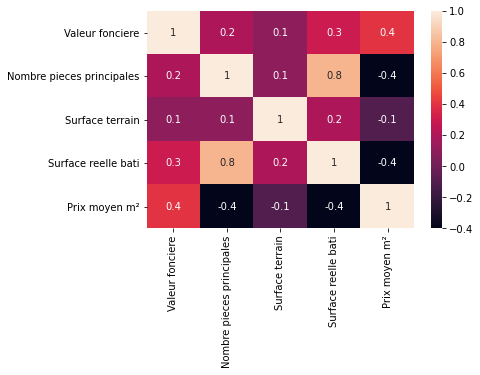

In [6]:
matrice_corr = cleaned_dataframe.corr().round(1)
sns.heatmap(data=matrice_corr, annot=True)

In [7]:
X = pd.DataFrame(np.c_[cleaned_dataframe['Nombre pieces principales'],cleaned_dataframe['Surface terrain'],cleaned_dataframe['Surface reelle bati'], cleaned_dataframe['Prix moyen m²']], columns = ['Nombre pieces principales','Surface terrain','Surface reelle bati', 'Prix moyen m²'])

Y = cleaned_dataframe['Valeur fonciere']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

del cleaned_dataframe
del X
del Y

In [8]:
sc = StandardScaler()
X_train_flat = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Sauvegarde du modele

In [9]:
filepath = "./model/model.json"

randomforest = randomforestclass.RandomForest(X_train=X_train_flat, Y_train=y_train, data=X_train) 
 
randomforest.save_json(filepath)